#**Top 3 Cryptocurrencies Analysis and Volatility prediction with hybrid 'LSTM-GARCH' model** <br><br>

Zarmina Ursino <br>
zarmina.ursino@studio.unibo.it




In [ ]:
!pip install mplfinance


     |████████████████████████████████| 70 kB 7.2 MB/s 


In [ ]:
pip install arch

     |████████████████████████████████| 902 kB 16.9 MB/s 
     |████████████████████████████████| 9.8 MB 63.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


#MODULES

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import math
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")


#Data Loading

In [ ]:
df_eth = pd.read_csv('ETH-USD.csv', parse_dates=True)
df_eth = df_eth.reset_index()

df_xrp = pd.read_csv('xrp.csv', parse_dates=True)
df_xrp = df_xrp.reset_index()

df_bit = pd.read_csv('bitcoin.csv', parse_dates=True)
df_bit = df_bit.reset_index()


#Data Exploration and Cleaning

In [ ]:
print(df_eth.shape)
print(df_xrp.shape)
print(df_bit.shape)


(2212, 8)
(2536, 8)
(1612, 8)


##Data setting

In [ ]:
def data_setting(df):
  df['Date']=pd.to_datetime(df['Date'])
  df=df[~(df['Date']<'2017-11-09')]
  df=df[~(df['Date']>'2021-08-26')]
  return df

In [ ]:
df_eth=data_setting(df_eth) 
df_xrp=data_setting(df_xrp)
df_bit=data_setting(df_bit)

In [ ]:
print(df_eth.shape)
print(df_xrp.shape)
print(df_bit.shape)


(1387, 8)
(1387, 8)
(1387, 8)


##Trends Plot

In [ ]:
df_eth['100ma'] = df_eth['Close'].rolling(window = 100, min_periods = 0).mean()
df_xrp['100ma'] = df_xrp['Close'].rolling(window = 100, min_periods = 0).mean()
df_bit['100ma'] = df_bit['Close'].rolling(window = 100, min_periods = 0).mean()

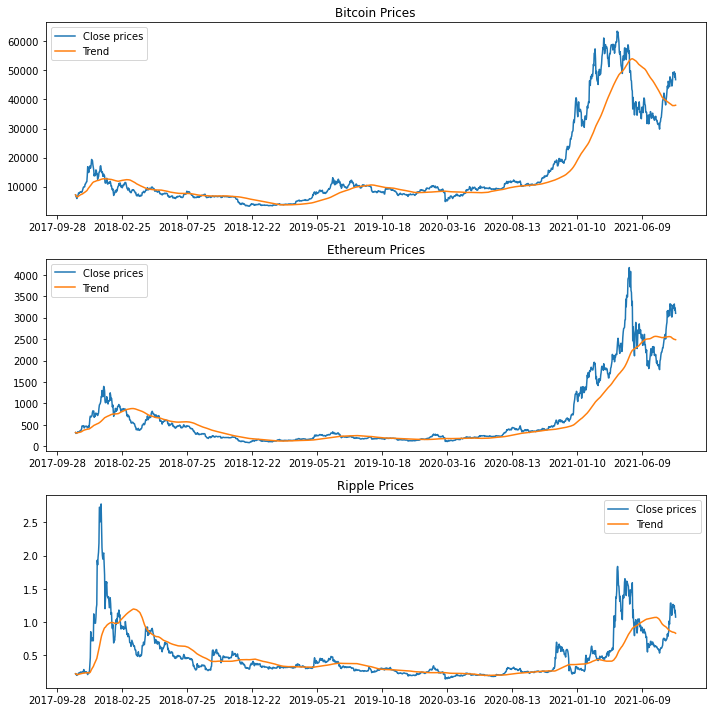

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].plot(df_bit.Date, df_bit.Close, label='Close prices')
ax[0].plot(df_bit.Date, df_bit['100ma'], label='Trend')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[0].set_title('Bitcoin Prices')
ax[0].legend()
ax[1].plot(df_eth.Date, df_eth.Close, label='Close prices')
ax[1].plot(df_eth.Date, df_eth['100ma'],  label='Trend')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[1].set_title('Ethereum Prices')
ax[1].legend()

ax[2].plot(df_xrp.Date, df_xrp.Close, label='Close prices')
ax[2].plot(df_xrp.Date, df_xrp['100ma'], label='Trend')
ax[2].xaxis.set_major_locator(plt.MaxNLocator(15)) # reduce number of x-labels
ax[2].set_title('Ripple Prices')
ax[2].legend()


plt.tight_layout()
plt.show()

##Total Traded

In [ ]:
df_eth['Total Traded'] = df_eth['Open']*df_eth['Volume']
df_xrp['Total Traded'] = df_xrp['Open']*df_xrp['Volume']
df_bit['Total Traded'] = df_bit['Open']*df_bit['Volume']

In [ ]:
df_eth.iloc[df_eth['Total Traded'].argmax()]


index                          2106
Date                     2021-05-13
Open                    3828.918457
High                    4032.563477
Low                     3549.407227
Close                   3715.148438
Adj Close               3715.148438
Volume                78398214539.0
Total Traded    300180370644222.875
Name: 2106, dtype: object

In [ ]:
df_xrp.iloc[df_xrp['Total Traded'].argmax()]


index                          2309
Date            2021-05-19 00:00:00
Open                        1.59055
High                        1.64286
Low                         0.87542
Close                        1.0617
Volume                   5026776064
Currency                        USD
100ma                      1.408515
Total Traded        7995338668.5952
Name: 2309, dtype: object

In [ ]:
df_bit.iloc[df_bit['Total Traded'].argmax()]


index                          3699
Date            2020-09-02 00:00:00
Open                        11914.4
High                        11947.5
Low                         11244.9
Close                       11413.3
Volume                     20255896
Currency                        USD
100ma                     10221.153
Total Traded    241336847302.399994
Name: 3699, dtype: object

##Candlesticks

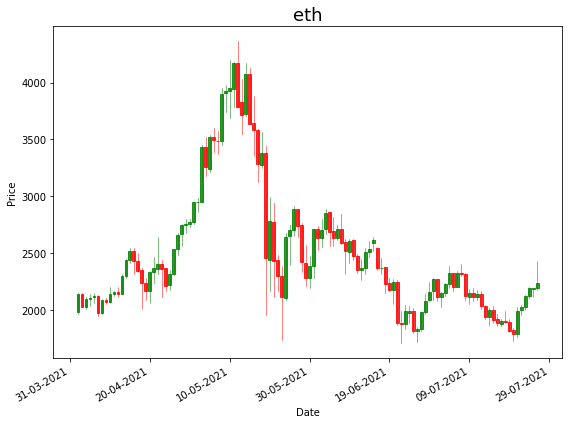

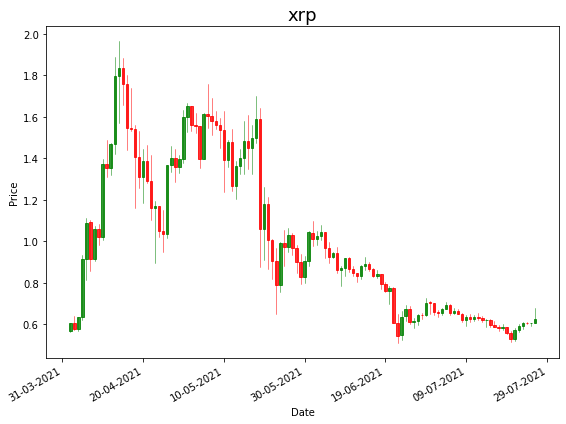

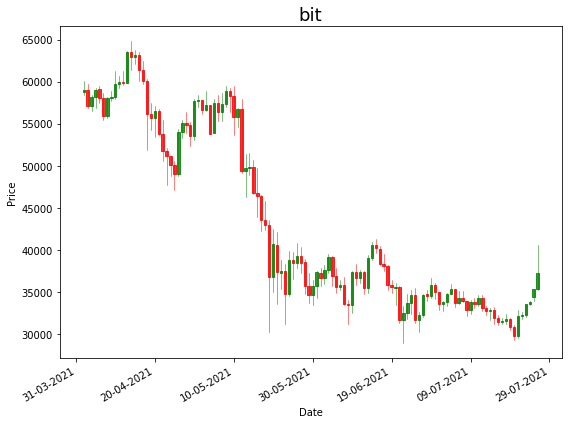

<Figure size 432x288 with 0 Axes>

In [ ]:
def candlestick(df,title):
  '''
  This function print the candlestick plot for each dataset 
  '''

  ohlc = df[(df['Date'] > '2021-04-01') & (df['Date'] <= '2021-07-26')]
  ohlc = ohlc.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
  ohlc['Date'] = pd.to_datetime(ohlc['Date'])
  ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
  ohlc = ohlc.astype(float)
  fig, ax = plt.subplots(figsize = (8,6))
  candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  date_format = mpl_dates.DateFormatter('%d-%m-%Y')
  ax.xaxis.set_major_formatter(date_format)
  ax.set_title(title, fontsize=18)
  fig.autofmt_xdate()
  fig.tight_layout()

#fig, axs = plt.subplots(3, 1, figsize=(20, 15))
a=candlestick(df=df_eth, title='eth')
b=candlestick(df=df_xrp, title='xrp')
c=candlestick(df=df_bit, title='bit')
ax[0]=a
ax[1]=b
ax[2]=c
plt.show()
plt.tight_layout()

#Volatility Calculation

In [ ]:
def volatility(df):
  '''
  This function calculates the volatility of the closing prices and adds 'Volatility' feature to the dataset 
  '''

  df['log_price'] = np.log(df['Close']) #I calculate the logarithmic return from prices
  df['pct_change'] = df['log_price'].diff() #I calculate the difference
  df['stdev'] = df['pct_change'].rolling(window=30, center=False).std() #I calculate the standard deviation
  df['Volatility'] = df['stdev'] * (365**0.5) # Annualize.

  plt.figure(figsize=(16,6))
  df['Volatility'].plot()
  plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
  plt.show()

  
  return df




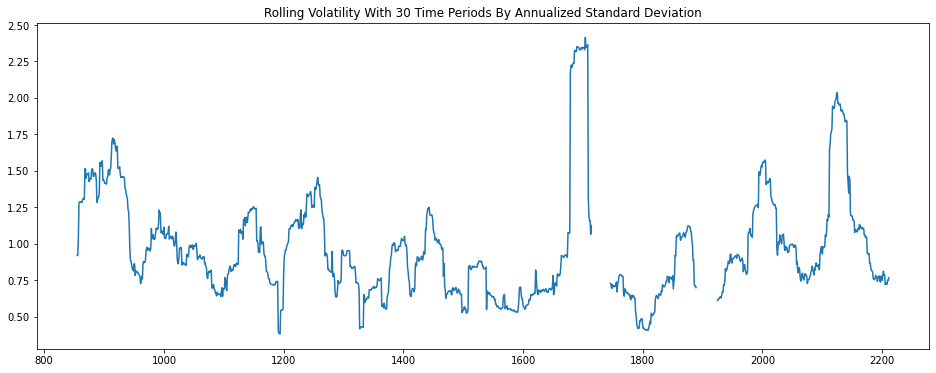

In [ ]:
df_eth=volatility(df_eth)


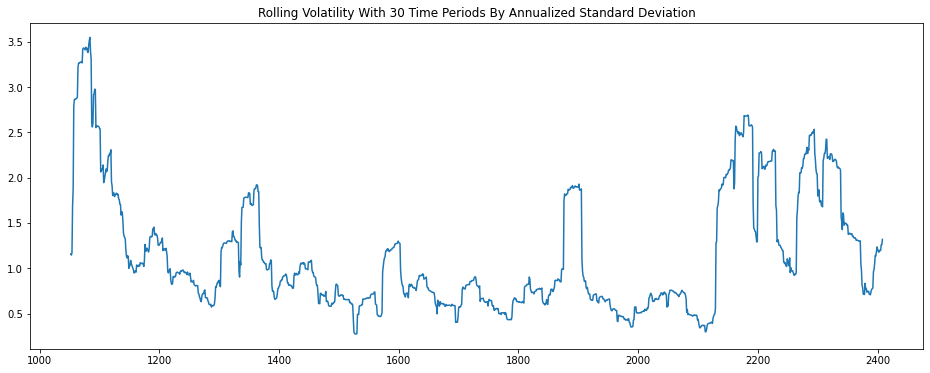

In [ ]:
df_xrp=volatility(df_xrp)


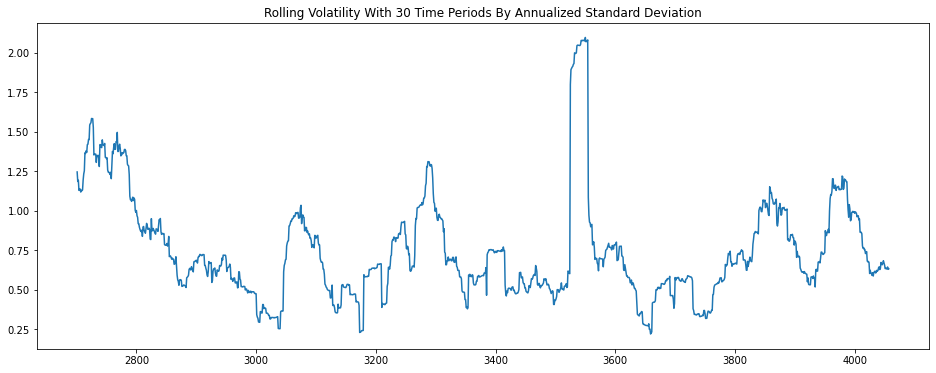

In [ ]:
df_bit=volatility(df_bit)

#Models

Implementation of 3 models.<br>
The evaluation is done by calculating the RMSE. 

###Evaluation with RSME

In [ ]:
def rmse_tr(predictions, targets): 
  '''
  It calculates the Root Mean Squared Error
  '''
  return np.sqrt(((predictions - targets) ** 2).mean())



##GARCH

$$\sigma^2(t) = \alpha \times \sigma^2(t-1) + \beta \times e^2(t-1) + w$$

In [ ]:
def garch_model(df):
  '''
  Function that builds the GJR-GARCH model 
  -p=1
  -q=1
  -alpha, beta, gamma and omega values are fetched from the summary of the fitting

  '''
  df = df.drop(["Date"], axis=1)


  plt.figure(figsize=(16,6))
  df['Volatility'].plot()
  plt.title("Rolling Volatility With 30 Time Periods By Annualized Standard Deviation")
  plt.show()



  df = df.dropna()

  vol = df["Volatility"] 

  am = arch_model(vol, vol='Garch', p=1, o=1, q=1, dist='Normal')


  res1 = am.fit()
  res1.summary()

  df1 = pd.DataFrame(columns=['test', 'I'])

  df1['test'] = res1.resid 
  df1.loc[df1['test'] < 0, 'I'] = 1
  df1["I"] = df1["I"].fillna(0)

  df['forecast_vol'] = np.sqrt(res1.params['omega'] + res1.params['alpha[1]'] * res1.resid**2 + res1.params['gamma[1]'] * res1.resid**2 * df1['I'] + res1.conditional_volatility**2 * res1.params['beta[1]'] ) ## Scaled from 0.1 to 0.01 when *3 then rmse minimum 0.49788 else 0.619080



  plt.figure(figsize=(16,6))
  df["Volatility"].plot()
  df["forecast_vol"].plot()
  plt.title("Real Rolling Volatility vs Forecast by GJR-GARCH(1,1)")
  plt.legend()
  plt.show()
  print("\n\n=================================EVALUATION===================================\n")
  score = rmse_tr(df.loc[df.index[300:], 'forecast_vol'], df.loc[df.index[300:], 'Volatility'])
  print("Root Mean Squared Error of the GARCH(1,1) model is calculated as ",score)

  return df



###Garch Ethereum

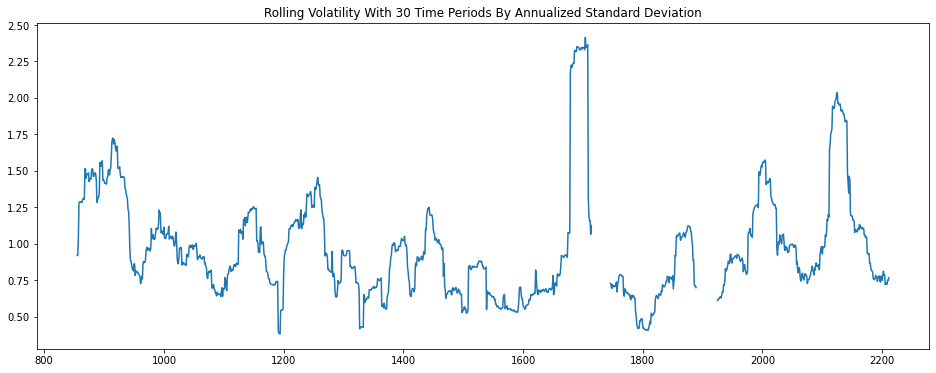

Iteration:      1,   Func. Count:      7,   Neg. LLF: -53.05998866163634
Iteration:      2,   Func. Count:     22,   Neg. LLF: -167.0810941833073
Iteration:      3,   Func. Count:     30,   Neg. LLF: -239.26367785563696
Iteration:      4,   Func. Count:     38,   Neg. LLF: -253.66458766635202
Iteration:      5,   Func. Count:     46,   Neg. LLF: -260.09989578401087
Iteration:      6,   Func. Count:     54,   Neg. LLF: -267.736774112024
Iteration:      7,   Func. Count:     62,   Neg. LLF: -294.5305828072651
Iteration:      8,   Func. Count:     70,   Neg. LLF: -296.30197117143894
Iteration:      9,   Func. Count:     78,   Neg. LLF: -303.58511955101045
Iteration:     10,   Func. Count:     85,   Neg. LLF: -310.1809730872685
Iteration:     11,   Func. Count:     93,   Neg. LLF: -310.97813291195615
Iteration:     12,   Func. Count:    100,   Neg. LLF: -314.14326596981255
Iteration:     13,   Func. Count:    107,   Neg. LLF: -314.45564670681216
Iteration:     14,   Func. Count:    114,   

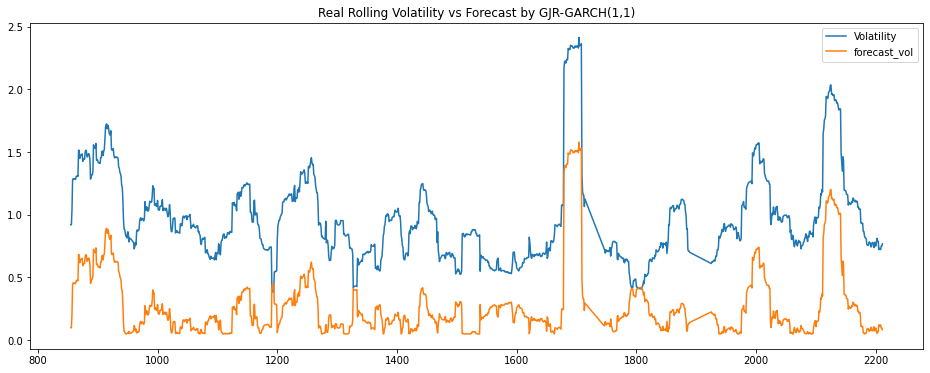



=================================EVALUATION===================================

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.6971294396705378


In [ ]:
df_eth=garch_model(df_eth)

###Garch Ripple 

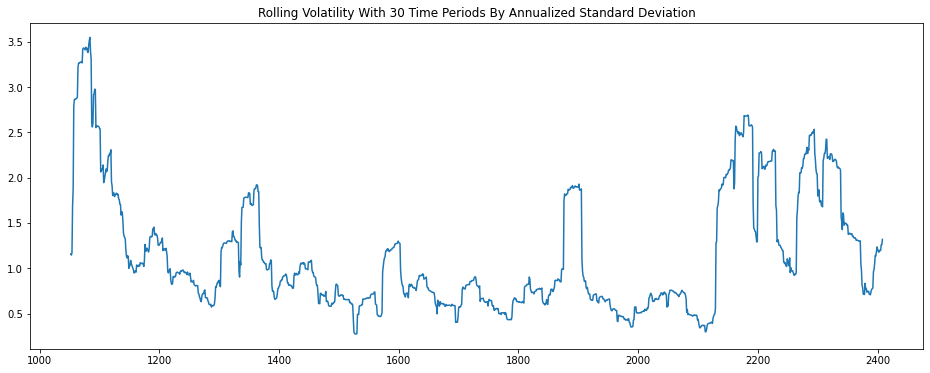

Iteration:      1,   Func. Count:      7,   Neg. LLF: 872.4887845750864
Iteration:      2,   Func. Count:     23,   Neg. LLF: 539.9273508721421
Iteration:      3,   Func. Count:     32,   Neg. LLF: 397.77220551356913
Iteration:      4,   Func. Count:     40,   Neg. LLF: 347.10530280304056
Iteration:      5,   Func. Count:     48,   Neg. LLF: 318.2968962410472
Iteration:      6,   Func. Count:     56,   Neg. LLF: 293.39698476406454
Iteration:      7,   Func. Count:     64,   Neg. LLF: 270.9022411443941
Iteration:      8,   Func. Count:     72,   Neg. LLF: 256.0607419581926
Iteration:      9,   Func. Count:     80,   Neg. LLF: 236.76499247182042
Iteration:     10,   Func. Count:     87,   Neg. LLF: 165.4438489234995
Iteration:     11,   Func. Count:     95,   Neg. LLF: 143.53073061044088
Iteration:     12,   Func. Count:    103,   Neg. LLF: 139.60637085457395
Iteration:     13,   Func. Count:    112,   Neg. LLF: 138.00165524383962
Iteration:     14,   Func. Count:    119,   Neg. LLF: 133

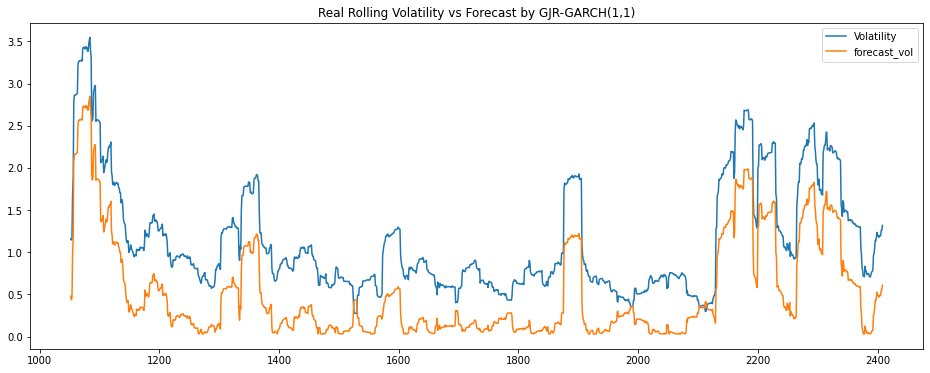



=================================EVALUATION===================================

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.6222032424652556


In [ ]:
df_xrp=garch_model(df_xrp)

###Garch Bitcoin

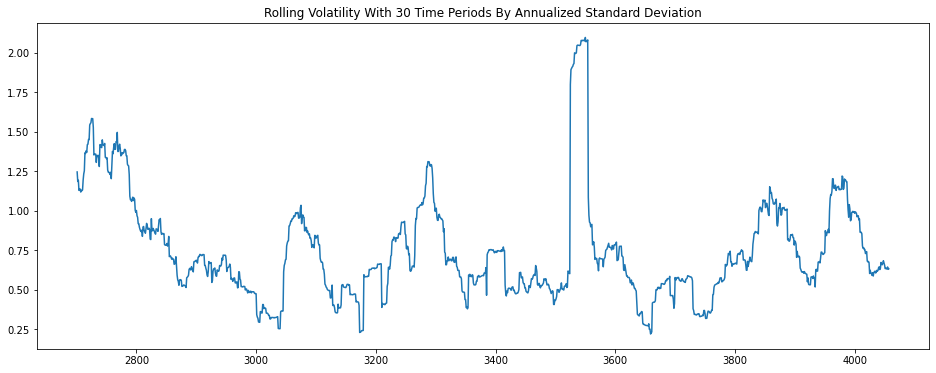

Iteration:      1,   Func. Count:      7,   Neg. LLF: -234.3906462011016
Iteration:      2,   Func. Count:     23,   Neg. LLF: -355.766997929803
Iteration:      3,   Func. Count:     31,   Neg. LLF: -396.1415982430856
Iteration:      4,   Func. Count:     39,   Neg. LLF: -397.9181169161915
Iteration:      5,   Func. Count:     47,   Neg. LLF: -414.0216718090463
Iteration:      6,   Func. Count:     55,   Neg. LLF: -419.71941150474663
Iteration:      7,   Func. Count:     63,   Neg. LLF: -427.8469582815925
Iteration:      8,   Func. Count:     71,   Neg. LLF: -431.88715368836085
Iteration:      9,   Func. Count:     79,   Neg. LLF: -436.60640438861674
Iteration:     10,   Func. Count:     87,   Neg. LLF: -440.9363369152661
Iteration:     11,   Func. Count:     94,   Neg. LLF: -457.5521118574011
Iteration:     12,   Func. Count:    102,   Neg. LLF: -461.37004860406165
Iteration:     13,   Func. Count:    110,   Neg. LLF: -462.0268807881896
Iteration:     14,   Func. Count:    117,   Neg.

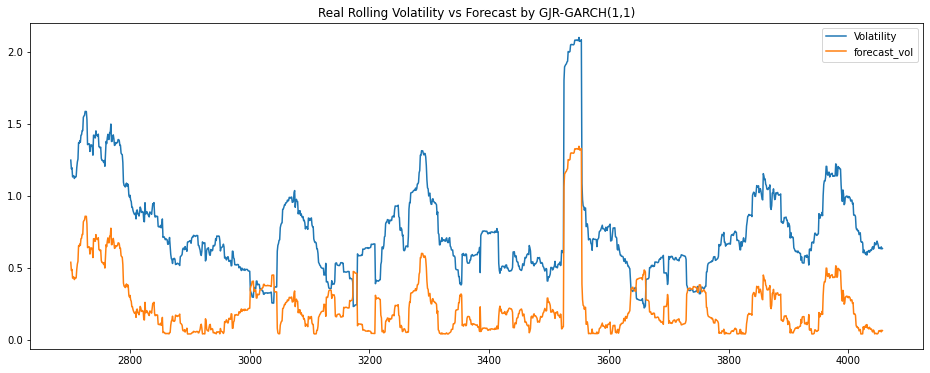



=================================EVALUATION===================================

Root Mean Squared Error of the GARCH(1,1) model is calculated as  0.5423051010434152


In [ ]:
df_bit=garch_model(df_bit)

##LSTM

In [ ]:
def lstm_model(df):
  '''
  Function that builds the LSTM model
  '''
  training_set = df.iloc[:, 10:11].values
  X_train = []
  y_train = []
  for i in range(300, df.shape[0]):
      X_train.append(training_set[i-300:i,0])
      y_train.append(training_set[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)


  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


  # Initialising the RNN
  model = Sequential()

  # Adding the first LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  model.add(Dropout(0.1))

  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10, return_sequences = True))
  model.add(Dropout(0.1))

  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10, return_sequences = True))
  model.add(Dropout(0.1))

  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10))
  model.add(Dropout(0.1))

  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  model.fit(X_train, y_train, epochs = 20, batch_size = 32)

  model.summary()


  model.save('my_modelp1.h5')
  

  from keras.models import load_model
  model = load_model('my_modelp1.h5')


  predicted_stock_price = model.predict(X_train)

  # Visualising the results
  plt.figure(figsize=(18,6))
  plt.plot(df.iloc[300:, 10:11].values, color = 'red', label = 'Observed Volatility')
  plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM')
  plt.title('Real Rolling Volatility vs Forecast of LSTM')
  plt.xlabel('Time')
  plt.ylabel('Volatility')
  plt.legend()
  plt.show()


  print("=================================EVALUATION===================================")
  score2 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[300:], 'Volatility']))
  print("Root Mean Squared Error of the model is calculated as ",score2)


###LSTM Ethereum

Epoch 1/20
31/31 [==============================] - 22s 434ms/step - loss: 0.3179
Epoch 2/20
31/31 [==============================] - 13s 431ms/step - loss: 0.1410
Epoch 3/20
31/31 [==============================] - 15s 495ms/step - loss: 0.1393
Epoch 4/20
31/31 [==============================] - 13s 436ms/step - loss: 0.1176
Epoch 5/20
31/31 [==============================] - 14s 435ms/step - loss: 0.0934
Epoch 6/20
31/31 [==============================] - 14s 436ms/step - loss: 0.0780
Epoch 7/20
31/31 [==============================] - 14s 436ms/step - loss: 0.0705
Epoch 8/20
31/31 [==============================] - 13s 433ms/step - loss: 0.0560
Epoch 9/20
31/31 [==============================] - 13s 432ms/step - loss: 0.0565
Epoch 10/20
31/31 [==============================] - 13s 432ms/step - loss: 0.0521
Epoch 11/20
31/31 [==============================] - 13s 435ms/step - loss: 0.0543
Epoch 12/20
31/31 [==============================] - 14s 435ms/step - loss: 0.0456
Epoch 13/20
3

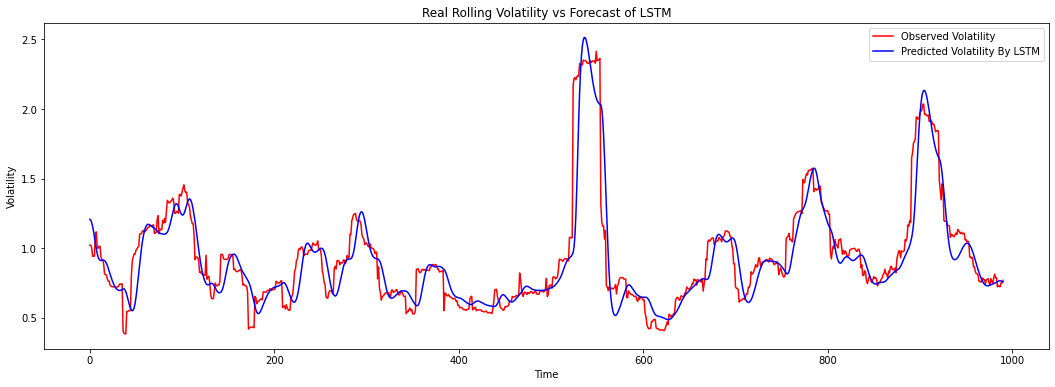

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.5223026860375644


In [ ]:
lstm_model(df_eth)

###LSTM Ripple

Epoch 1/20
34/34 [==============================] - 23s 439ms/step - loss: 0.7346
Epoch 2/20
34/34 [==============================] - 15s 446ms/step - loss: 0.3214
Epoch 3/20
34/34 [==============================] - 15s 441ms/step - loss: 0.1834
Epoch 4/20
34/34 [==============================] - 15s 447ms/step - loss: 0.1401
Epoch 5/20
34/34 [==============================] - 15s 443ms/step - loss: 0.1202
Epoch 6/20
34/34 [==============================] - 15s 442ms/step - loss: 0.0982
Epoch 7/20
34/34 [==============================] - 15s 437ms/step - loss: 0.1035
Epoch 8/20
34/34 [==============================] - 15s 440ms/step - loss: 0.0989
Epoch 9/20
34/34 [==============================] - 15s 437ms/step - loss: 0.0865
Epoch 10/20
34/34 [==============================] - 15s 440ms/step - loss: 0.0949
Epoch 11/20
34/34 [==============================] - 15s 441ms/step - loss: 0.0875
Epoch 12/20
34/34 [==============================] - 15s 445ms/step - loss: 0.0877
Epoch 13/20
3

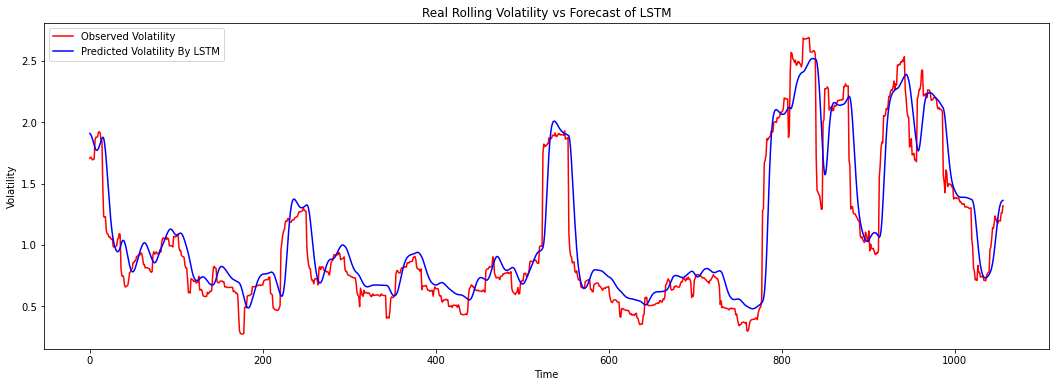

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.8258696266553099


In [ ]:
lstm_model(df_xrp)

###LSTM Bitcoin

Epoch 1/20
34/34 [==============================] - 23s 444ms/step - loss: 0.8112
Epoch 2/20
34/34 [==============================] - 15s 438ms/step - loss: 0.3582
Epoch 3/20
34/34 [==============================] - 15s 439ms/step - loss: 0.3304
Epoch 4/20
34/34 [==============================] - 15s 438ms/step - loss: 0.2309
Epoch 5/20
34/34 [==============================] - 15s 439ms/step - loss: 0.1706
Epoch 6/20
34/34 [==============================] - 15s 437ms/step - loss: 0.1395
Epoch 7/20
34/34 [==============================] - 15s 441ms/step - loss: 0.1076
Epoch 8/20
34/34 [==============================] - 15s 439ms/step - loss: 0.0923
Epoch 9/20
34/34 [==============================] - 15s 437ms/step - loss: 0.0917
Epoch 10/20
34/34 [==============================] - 15s 444ms/step - loss: 0.0841
Epoch 11/20
34/34 [==============================] - 15s 440ms/step - loss: 0.0847
Epoch 12/20
34/34 [==============================] - 15s 444ms/step - loss: 0.0718
Epoch 13/20
3

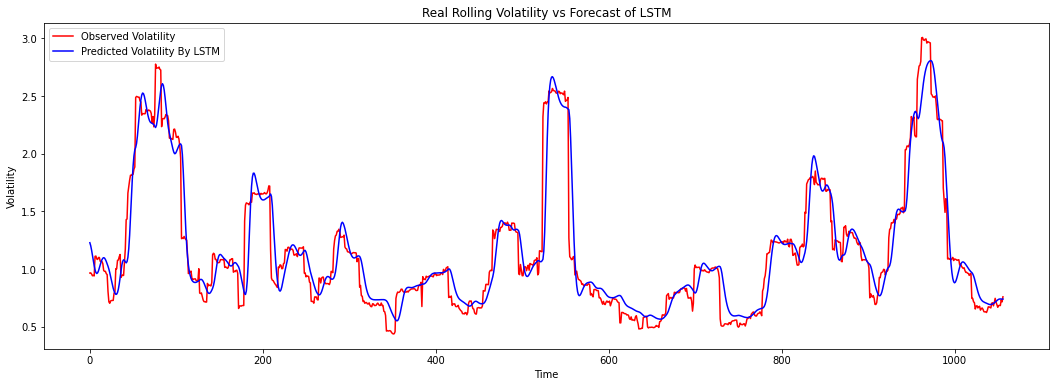

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.7810342929066005


In [ ]:
lstm_model(df_bit)

##GARCH+LSTM

In [ ]:
def garch_lstm_model(df):
  '''
  Function that builds the Hybrid Model, by combining Garch(1, 1) and LSTM
  '''
  training_set = df.iloc[:, 10:12].values
  X_train = []
  y_train = []
  for i in range(300, df.shape[0]):
      X_train.append(training_set[i-300:i,:])
      y_train.append(training_set[i,0])
  X_train, y_train = np.array(X_train), np.array(y_train)


  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))     ##Did 1 instead of 2


  # Initialising the RNN
  model = Sequential()

  # Adding the first LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 2))) #,1 instead of ,2 in the end)
  model.add(Dropout(0.1))

  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10, return_sequences = True))
  model.add(Dropout(0.1))

  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10, return_sequences = True))
  model.add(Dropout(0.1))

  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 10))
  model.add(Dropout(0.1))

  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  model.fit(X_train, y_train, epochs = 20, batch_size = 32)


  model.save('my_modelp2.h5')



  from keras.models import load_model
  model = load_model('my_modelp2.h5')


  predicted_stock_price = model.predict(X_train)


  # Visualising the results
  plt.figure(figsize=(18,6))
  plt.plot(df.iloc[300:, 10:11].values, color = 'red', label = 'Observed Volatility')
  plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Volatility By LSTM_GJR-GARCH(1,1)')
  plt.title('Real Rolling Volatility vs Forecast of LSTM_GJR-GARCH(1,1)')
  plt.xlabel('Time')
  plt.ylabel('Volatility')
  plt.legend()
  plt.show()

  print("=================================EVALUATION===================================")
  score3 = rmse_tr(predicted_stock_price, np.array(df.loc[df.index[300:], 'Volatility']))
  print("Root Mean Squared Error of the model is calculated as ",score3)


### GARCH+LSTM Ethereum

Epoch 1/20
31/31 [==============================] - 21s 432ms/step - loss: 0.5833
Epoch 2/20
31/31 [==============================] - 13s 435ms/step - loss: 0.1631
Epoch 3/20
31/31 [==============================] - 13s 430ms/step - loss: 0.1518
Epoch 4/20
31/31 [==============================] - 14s 441ms/step - loss: 0.1143
Epoch 5/20
31/31 [==============================] - 13s 436ms/step - loss: 0.0891
Epoch 6/20
31/31 [==============================] - 13s 434ms/step - loss: 0.0807
Epoch 7/20
31/31 [==============================] - 13s 430ms/step - loss: 0.0769
Epoch 8/20
31/31 [==============================] - 13s 424ms/step - loss: 0.0548
Epoch 9/20
31/31 [==============================] - 13s 427ms/step - loss: 0.0537
Epoch 10/20
31/31 [==============================] - 13s 430ms/step - loss: 0.0504
Epoch 11/20
31/31 [==============================] - 13s 418ms/step - loss: 0.0539
Epoch 12/20
31/31 [==============================] - 13s 424ms/step - loss: 0.0466
Epoch 13/20
3

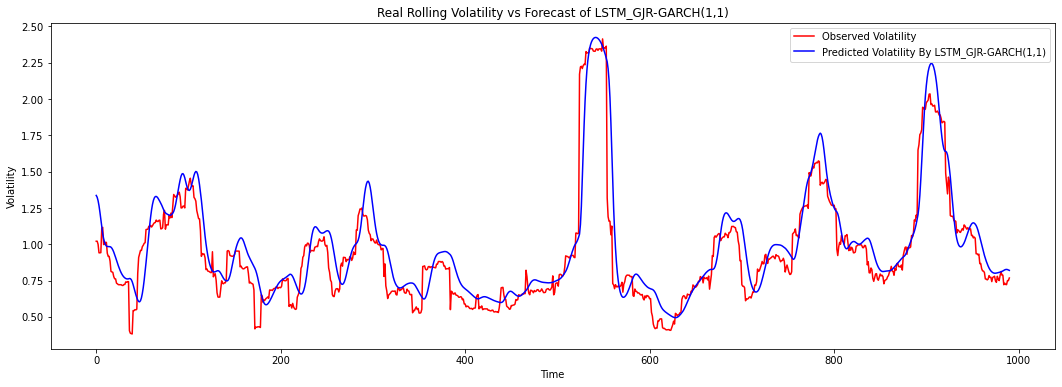

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.542264490558765


In [ ]:
garch_lstm_model(df_eth)

###GARCH+LSTM Ripple

Epoch 1/20
34/34 [==============================] - 22s 423ms/step - loss: 0.6675
Epoch 2/20
34/34 [==============================] - 15s 427ms/step - loss: 0.2512
Epoch 3/20
34/34 [==============================] - 15s 429ms/step - loss: 0.1418
Epoch 4/20
34/34 [==============================] - 14s 419ms/step - loss: 0.1150
Epoch 5/20
34/34 [==============================] - 14s 420ms/step - loss: 0.1127
Epoch 6/20
34/34 [==============================] - 14s 421ms/step - loss: 0.1039
Epoch 7/20
34/34 [==============================] - 14s 424ms/step - loss: 0.0924
Epoch 8/20
34/34 [==============================] - 14s 424ms/step - loss: 0.0856
Epoch 9/20
34/34 [==============================] - 14s 422ms/step - loss: 0.0935
Epoch 10/20
34/34 [==============================] - 14s 425ms/step - loss: 0.0802
Epoch 11/20
34/34 [==============================] - 15s 427ms/step - loss: 0.0836
Epoch 12/20
34/34 [==============================] - 14s 420ms/step - loss: 0.0842
Epoch 13/20
3

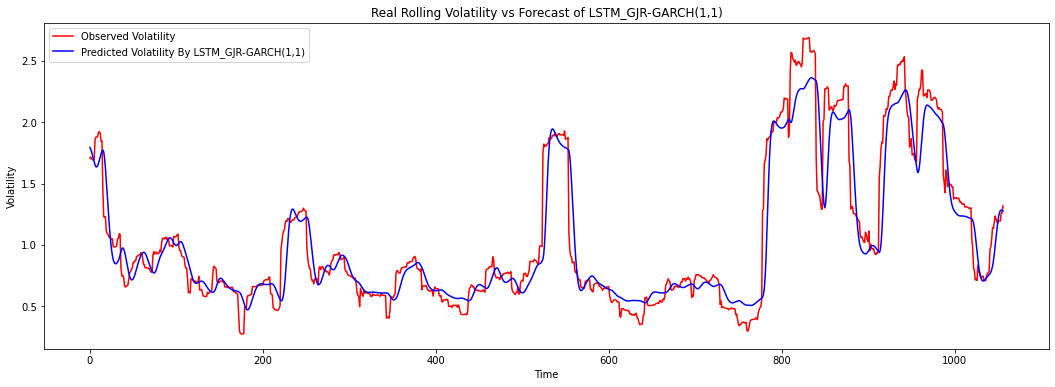

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.8050234146532611


In [ ]:
garch_lstm_model(df_xrp)

###GARCH+LSTM Bitcoin

Epoch 1/20
34/34 [==============================] - 22s 426ms/step - loss: 0.7704
Epoch 2/20
34/34 [==============================] - 15s 431ms/step - loss: 0.2376
Epoch 3/20
34/34 [==============================] - 15s 430ms/step - loss: 0.1757
Epoch 4/20
34/34 [==============================] - 14s 423ms/step - loss: 0.1540
Epoch 5/20
34/34 [==============================] - 15s 428ms/step - loss: 0.1316
Epoch 6/20
34/34 [==============================] - 14s 423ms/step - loss: 0.1130
Epoch 7/20
34/34 [==============================] - 15s 429ms/step - loss: 0.0965
Epoch 8/20
34/34 [==============================] - 15s 429ms/step - loss: 0.0899
Epoch 9/20
34/34 [==============================] - 15s 427ms/step - loss: 0.0860
Epoch 10/20
34/34 [==============================] - 15s 431ms/step - loss: 0.0920
Epoch 11/20
34/34 [==============================] - 14s 422ms/step - loss: 0.0841
Epoch 12/20
34/34 [==============================] - 14s 421ms/step - loss: 0.0780
Epoch 13/20
3

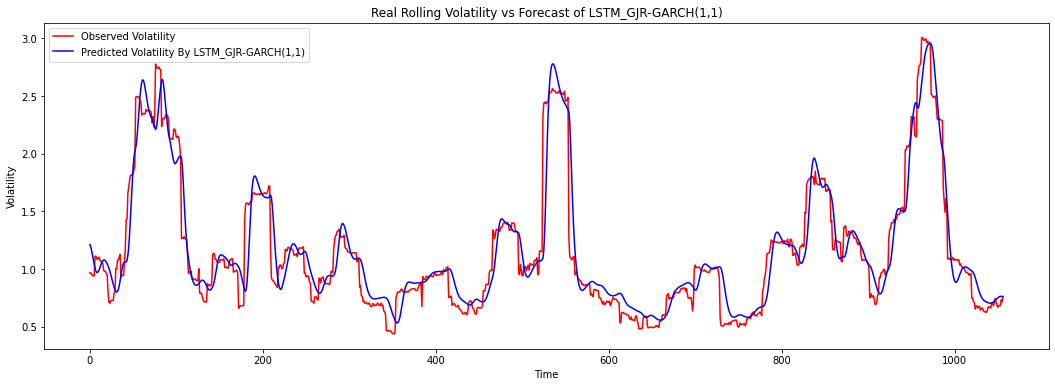

=================================EVALUATION===================================
Root Mean Squared Error of the model is calculated as  0.7871026261560092


In [ ]:
garch_lstm_model(df_bit)